In [0]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17426527302331411666, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15130963087362184747
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11975305088202968838
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8422957575031298730
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
! git clone https://github.com/Mertkaann/Palm-Fiction.git

Cloning into 'Palm-Fiction'...
remote: Enumerating objects: 5695, done.
remote: Counting objects: 100% (5695/5695), done.
remote: Compressing objects: 100% (2862/2862), done.
remote: Total 9241 (delta 9), reused 5695 (delta 9), pack-reused 3546
Receiving objects: 100% (9241/9241), 246.01 MiB | 14.21 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (17713/17713), done.


In [0]:
import os
import random

In [0]:
curr_path = os.getcwd()
dataset = os.path.join(curr_path,"Palm-Fiction","annotated_frames","cam1")
bounding_boxes = os.path.join(curr_path,"Palm-Fiction","bounding_boxes","cam1")
joints_path = os.path.join(curr_path,"Palm-Fiction","projections_2d","cam1")

dataset,bounding_boxes,joints_path

('/content/Palm-Fiction/annotated_frames/cam1',
 '/content/Palm-Fiction/bounding_boxes/cam1',
 '/content/Palm-Fiction/projections_2d/cam1')

# Data Visualization

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import pandas as pd
import numpy as np

In [0]:
def get_bound(path):
  with open(path, 'r') as reader:
    bounds = reader.readlines()
    bounds = [bound.split(' ')[1] for bound in bounds]

  bounds = [int(i) for i in bounds]
  #print("top, left, bottom, right")
  #print(bounds)

  bound_list = [['top_left',bounds[1],bounds[0]],
                ['top_right',bounds[3],bounds[0]],
                ['bottom_left',bounds[1],bounds[2]],
                ['bottom_right',bounds[3],bounds[2]]]
  #row_list.append(bound_list)

  bound_df = pd.DataFrame(bound_list,columns=["name","x","y"])
  bound_df.set_index('name',inplace=True)
  return bound_df

In [0]:
def get_bound_width_heght(bound):
  width = bound.loc['top_right']['x'] - bound.loc['top_left']['x']
  height =  bound.loc['bottom_left']['y'] - bound.loc['top_left']['y']
  return width,height

In [0]:
def get_joints(path):
  with open(path, 'r') as reader:
    joints = reader.readlines()
    joints = [joint.split(' ') for joint in joints]
  for joint in joints:
    joint[1] = float(joint[1])
    joint[2] = float(joint[2])
  joints = pd.DataFrame(joints,columns=["name","x","y"])
  return joints


In [0]:
def get_img(path):
  img = plt.imread(path)
  return img

In [0]:
def get_item(index):
  if index == -1:
    index = random.randint(0,600)
  sample_img = os.path.join(dataset,str(index)+"_webcam_1.jpg")
  sample_joints = os.path.join(joints_path,str(index)+"_jointsCam_1.txt")
  sample_bound = os.path.join(bounding_boxes,str(index)+"_bbox_1.txt")
  #print(index)
  #===============================================================#
  img = get_img(sample_img)
  #===============================================================#
  joints = get_joints(sample_joints)
  #===============================================================#
  bound_df = get_bound(sample_bound)
  #===============================================================#
  return img,joints,bound_df

In [0]:
def plot_everything(img,joints,bound):
  plt.imshow(img)
  plt.scatter(joints['x'],joints['y'])
  plt.scatter(bound['x'], bound['y'])

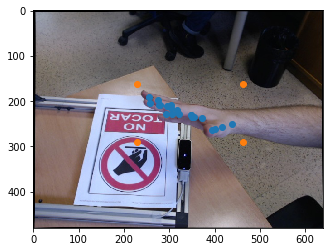

In [0]:
img,joints,bound = get_item(-1)
plot_everything(img,joints,bound)


# Data Preprocessing

In [0]:
import cv2

In [0]:
def crop_img(img,joints,bound):
  cropped_img = img[bound.loc['top_left']['y']:bound.loc['bottom_left']['y'],bound.loc['top_left']['x']:bound.loc['top_right']['x']]
  joints['x'] = joints['x']-bound.loc['top_left']['x']
  joints['y'] = joints['y']-bound.loc['top_left']['y']
  bound['x'] = bound['x']-bound.loc['top_left']['x']
  bound['y'] = bound['y']-bound.loc['top_left']['y']
  return cropped_img,joints,bound


In [0]:
def pad_img(img,bound,max_width,max_height):
  width,height = get_bound_width_heght(bound)
  top = left = 0
  bottom = max_width - height
  right = max_width - width
  padded_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, None, 1)
  return padded_img

(480, 640, 3)

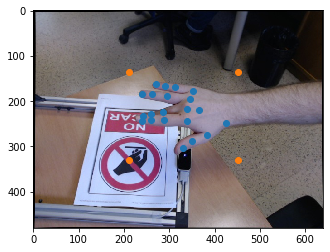

In [0]:
img,joints,bound = get_item(-1)
plot_everything(img,joints,bound)

img.shape

In [0]:
#Find Max height and width for hand images 
max_width= -1
max_height= -1

for f in os.listdir(bounding_boxes):
  bound_path = os.path.join(bounding_boxes,f)
  #index = f.split('_')[0]
  #img,joints,bound = get_item(index)
  bound = get_bound(bound_path)
  width,height = get_bound_width_heght(bound)
  #cropped_img,joints,bound = crop_img(img,joints,bound)
  #plot_everything(cropped_img,joints,bound)
  #print(cropped_img.shape)
  #print(cropped_img.shape[0]*cropped_img.shape[1],bound_area)
  if width > max_width:
    max_width = width
  if height > max_height:
    max_height = height

max_height,max_width

(257, 263)

In [0]:
Padded_imgs_Path = "./Palm-Fiction/Padded_Imgs"
Padded_joints_Path = "./Palm-Fiction/Padded_Joints"
Padded_bound_Path = "./Palm-Fiction/Padded_Bound"

!mkdir ./Palm-Fiction/Padded_Imgs
!mkdir ./Palm-Fiction/Padded_Joints
!mkdir ./Palm-Fiction/Padded_Bound


In [0]:
from PIL import Image
from matplotlib import cm

In [0]:
for f in os.listdir(bounding_boxes):
  index = int(f.split('_')[0])
  img,joints,bound = get_item(index)

  cropped_img,joints,bound = crop_img(img,joints,bound)
  padded_img = pad_img(cropped_img,bound,max_width,max_height)
  print(f)
  plt.imsave(os.path.join(Padded_imgs_Path,str(index)+".jpg"), padded_img, cmap='Greys')
  #plot_everything(padded_img,joints,bound)
  #plt.show()


449_bbox_1.txt
360_bbox_1.txt
13_bbox_1.txt
282_bbox_1.txt
604_bbox_1.txt
637_bbox_1.txt
666_bbox_1.txt
367_bbox_1.txt
447_bbox_1.txt
72_bbox_1.txt
181_bbox_1.txt
294_bbox_1.txt
496_bbox_1.txt
288_bbox_1.txt
706_bbox_1.txt
239_bbox_1.txt
357_bbox_1.txt
308_bbox_1.txt
492_bbox_1.txt
320_bbox_1.txt
303_bbox_1.txt
478_bbox_1.txt
622_bbox_1.txt
554_bbox_1.txt
699_bbox_1.txt
323_bbox_1.txt
114_bbox_1.txt
329_bbox_1.txt
571_bbox_1.txt
494_bbox_1.txt
476_bbox_1.txt
368_bbox_1.txt
603_bbox_1.txt
687_bbox_1.txt
690_bbox_1.txt
578_bbox_1.txt
139_bbox_1.txt
541_bbox_1.txt
34_bbox_1.txt
498_bbox_1.txt
419_bbox_1.txt
186_bbox_1.txt
100_bbox_1.txt
47_bbox_1.txt
355_bbox_1.txt
57_bbox_1.txt
406_bbox_1.txt
340_bbox_1.txt
595_bbox_1.txt
416_bbox_1.txt
164_bbox_1.txt
686_bbox_1.txt
178_bbox_1.txt
667_bbox_1.txt
617_bbox_1.txt
125_bbox_1.txt
4_bbox_1.txt
274_bbox_1.txt
347_bbox_1.txt
333_bbox_1.txt
692_bbox_1.txt
194_bbox_1.txt
593_bbox_1.txt
415_bbox_1.txt
386_bbox_1.txt
278_bbox_1.txt
95_bbox_1.txt
483

In [0]:
!git config --global user.email "mert525kaan@gmail.com"
!git config --global user.name "Mertkaann"

In [0]:
#!rmdir Palm-Fiction/Padded_Imgs
#import shutil
#shutil.move(Padded_imgs_Path, "Palm-Fiction", copy_function = shutil.copytree)

In [0]:
%cd Palm-Fiction/
!git add .
!git status
!git commit -m "Added Padded_Imgs as sub-directory"
!git push origin

/content/Palm-Fiction
On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   Padded_Imgs/0.jpg
	new file:   Padded_Imgs/1.jpg
	new file:   Padded_Imgs/10.jpg
	new file:   Padded_Imgs/100.jpg
	new file:   Padded_Imgs/101.jpg
	new file:   Padded_Imgs/102.jpg
	new file:   Padded_Imgs/103.jpg
	new file:   Padded_Imgs/104.jpg
	new file:   Padded_Imgs/105.jpg
	new file:   Padded_Imgs/106.jpg
	new file:   Padded_Imgs/107.jpg
	new file:   Padded_Imgs/108.jpg
	new file:   Padded_Imgs/109.jpg
	new file:   Padded_Imgs/11.jpg
	new file:   Padded_Imgs/110.jpg
	new file:   Padded_Imgs/111.jpg
	new file:   Padded_Imgs/112.jpg
	new file:   Padded_Imgs/113.jpg
	new file:   Padded_Imgs/114.jpg
	new file:   Padded_Imgs/115.jpg
	new file:   Padded_Imgs/116.jpg
	new file:   Padded_Imgs/117.jpg
	new file:   Padded_Imgs/118.jpg
	new file:   Padded_Imgs/119.jpg
	new file:   Padded_Imgs/12.jpg
	new file:   Padded_Im

In [0]:
#!git remote rm origin
#!git remote add origin 
#'git@github.com:Mertkaann/Palm-Fiction.git'

In [0]:
#!pwd
#!git push -u origin master

In [0]:
#%cd Palm-Fiction/
#!git add .
#!git status


In [0]:
#!git commit -m "Added Padded_img"
#!git push origin
!git remote add origin https://<username>:<password>github@github.com/<username>/reponame.git

/bin/bash: username: No such file or directory
